# Problem Statement
The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal
As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 
In order to do this, you planned to build a sentiment-based product recommendation system

* First we'll go through the pre-processing¶
* Next we'll do some visualization to get meaningful insights of the data
* We'll try out different methods for text classification ( like Random Forest, SVM, XGBoost, Deep Learning)
Lets get started

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from itertools import chain
#from wordcloud import WordCloud
from fractions import Fraction
import re
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,recall_score,classification_report
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
import pickle
#import os
#os.listdir("../input")

In [2]:
#read the product reviews
prod_df=pd.read_csv('https://raw.githubusercontent.com/nveenkumr/SentimentAnalysis_ProductRecommendation/main/sample30.csv')
prod_df.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive


# Data Exploration and Preprocessing

In [3]:
#shape of dataframe
prod_df.shape

(30000, 15)

In [4]:
# checking the null values , We can see lots of null values in reviews_didPurchase , userCity, Province
prod_df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

`Currently there are no null values in reviews_text , And our prediction model will be beased on the text reviews`.

#### What are the words that people have used the most in their reviews ?

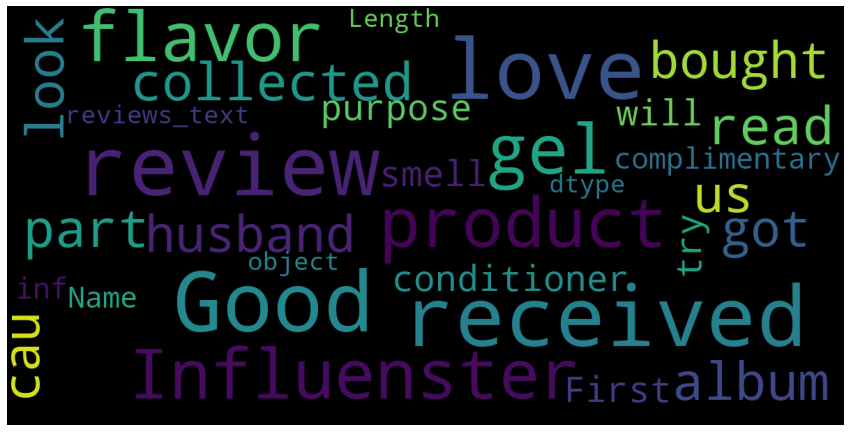

In [5]:
#import wordcloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordCloud(data, title= None):
    wordcloud= WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
        ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
show_wordCloud(prod_df['reviews_text'])

#### Lets check the Rating distribution

In [6]:
prod_df['reviews_rating'].value_counts()

5    20831
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

In [7]:
cnt_srs = prod_df['reviews_rating'].value_counts().head()
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Bluered',
        reversescale = True
    ),
)

layout = dict(
    title='Ratings distribution',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="Ratings")

#### Now let's have a look what do the length of the reviews tell about the ratings

In [8]:
prod_df['reviews_length']=prod_df['reviews_text'].apply(len)


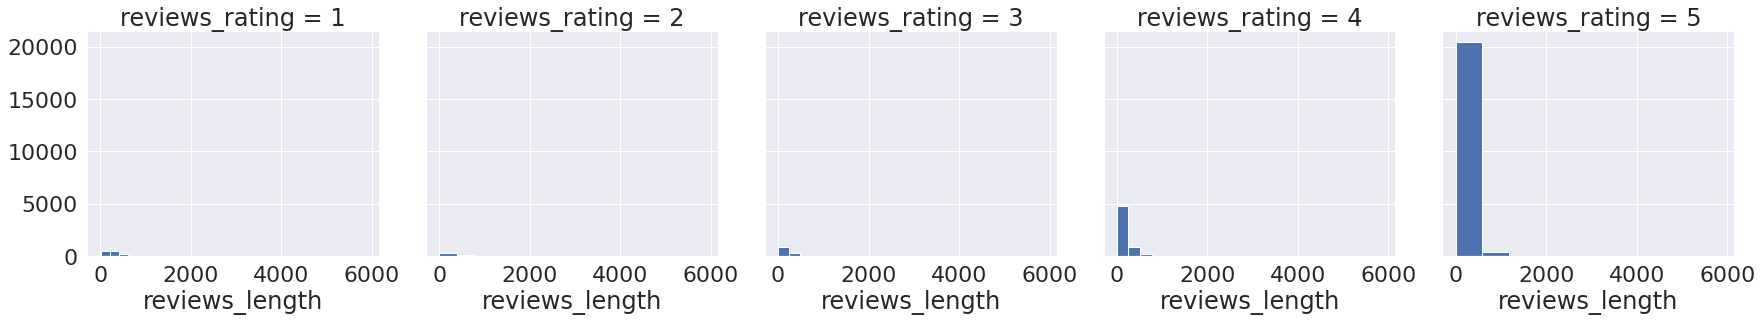

In [9]:
sns.set(font_scale=2.0)

g = sns.FacetGrid(prod_df,col='reviews_rating',size=5)
g.map(plt.hist,'reviews_length' , bins = 10)

In [10]:
prod_df['reviews_didPurchase'].fillna("Review N/A",inplace=True)

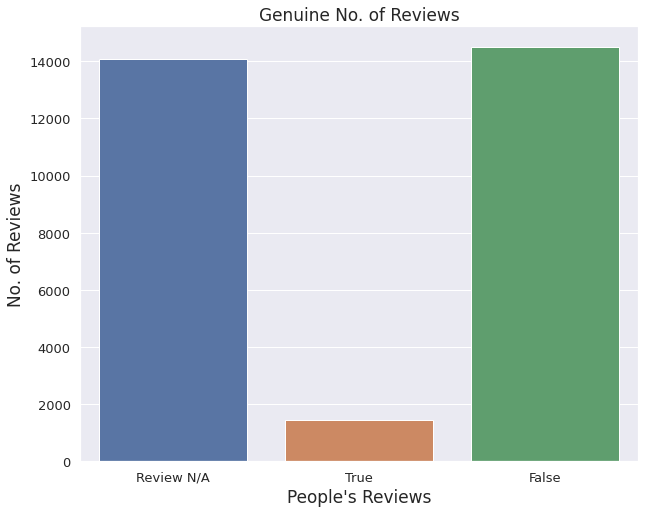

In [11]:
plt.figure(figsize=(10,8))
ax=sns.countplot(prod_df['reviews_didPurchase'])
ax.set_xlabel(xlabel="People's Reviews",fontsize=17)
ax.set_ylabel(ylabel='No. of Reviews',fontsize=17)
ax.axes.set_title('Genuine No. of Reviews',fontsize=17)
ax.tick_params(labelsize=13)

In [12]:
prod_df['reviews_didPurchase'].value_counts()

False         14498
Review N/A    14068
True           1434
Name: reviews_didPurchase, dtype: int64

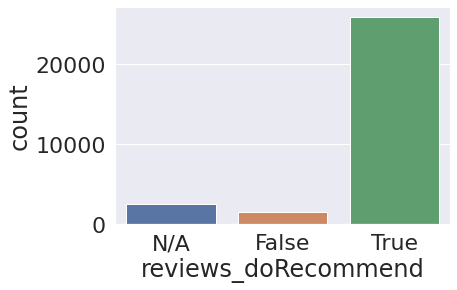

In [13]:
prod_df['reviews_doRecommend'].fillna("N/A",inplace=True)
sns.countplot(prod_df['reviews_doRecommend'])
plt.show()

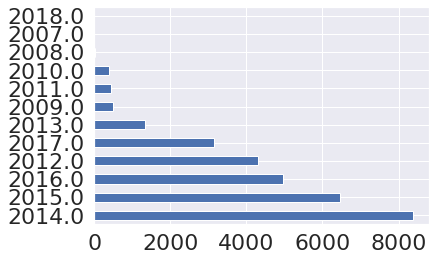

In [14]:
# checking the reviews in year , can see in 2014 has most number of reviews 
prod_df["date"] = pd.to_datetime(prod_df["reviews_date"], dayfirst=True, errors='coerce') 
prod_df['year']= prod_df['date'].dt.year
prod_df['year'].value_counts().plot.barh()
plt.show()

In [15]:
#Total Unique products
len(prod_df['name'].unique())

271

In [16]:
# As we know that there is one null record for user sentiment , let drop it
print("shape of prod_df before removing null records", prod_df.shape)
prod_df = prod_df[prod_df['user_sentiment'].notna()]
print("shape of prod_df after removing null records", prod_df.shape)

shape of prod_df before removing null records (30000, 18)
shape of prod_df after removing null records (29999, 18)


In [17]:
# Ratio of user_sentiment ( target column)
prod_df['user_sentiment'].value_counts()/len(prod_df['user_sentiment'])*100

Positive    88.776293
Negative    11.223707
Name: user_sentiment, dtype: float64

`By Looking at the sentiment colunm , we can see class imbalance problem i.e. only 11% of the rows are having negative sentiments`

## Pre-processing of review text

####  As we know that reviews with negative sentiments or lower ratings will have keywords like Not , wouldn't , WON'T. So we can exlude these from stops words so that our model can predict well.

In [18]:
negative_comments = prod_df[(prod_df['user_sentiment']=='Negative') & ((prod_df['reviews_text'].str.contains("NOT")) |(prod_df['reviews_text'].str.contains("N'T")) )][['reviews_text']]
negative_comments.head()

,reviews_text
40,I WON'T recommend this product to anyone
1238,HAVING A 3 MONTH OLD DAUGHTER MEANS I HAVE NO ...
1245,I RECENTLY USED FINISH QUANTUM FOR THE FIRST T...
1538,"IT WAS SUPPOSE TO BE A 2DISC ITEM,,,THERE WAS ..."
1797,Would ABSOLUTELY NOT recommend. We could only ...


In [19]:
# Downloads the data.
import nltk
nltk.download('stopwords')


# Using the stopwords.
from nltk.corpus import stopwords

# Initialize the stopwords
en_stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# checking the stop words
excluding_stops = [ sword for sword in en_stops if 'n\'t' in sword or 'not' in sword or 'no' in sword ]
print(excluding_stops)

['no', 'nor', 'not', "don't", 'now', "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't"]


In [21]:
# excluding the keywords like Not , wouldn't , WON'T.
en_stops_excluded = set(en_stops)-set(excluding_stops)
print(en_stops_excluded)

{'how', 'y', 'where', 'needn', 'other', 'under', 'too', 'do', "you'd", 'only', 'all', 'so', 'ain', 'was', "you're", 's', 'between', 'o', 'again', 'by', 'him', 'from', 'or', 'mightn', 'herself', 'ma', 'doing', 'below', 'few', 'wouldn', 'there', 'his', 'our', 'be', 'against', 'your', 'when', "it's", 'to', 'll', 'over', 'yourselves', 'having', 'before', 'out', 'why', 'has', 'were', 'aren', 'is', 'same', 'with', 'd', 'while', 'hasn', 'ourselves', 'i', 'been', 'during', "you'll", 'he', 'up', 've', 'who', 'of', 'ours', 'themselves', 'being', 'because', 'at', 'in', 'such', 'through', 'shan', 'didn', 'are', 'and', 'my', 'the', 'as', 'theirs', 'they', "you've", 'on', 'most', 'she', 'himself', 'hadn', 'but', 'them', 'had', 'me', 'yourself', 'what', 'myself', 'a', 'its', 'for', 'above', 'down', 'doesn', 'itself', 'than', 'then', 'some', 'own', 'won', 'just', "that'll", 'once', 'it', 'does', 'if', 'am', 'this', 'mustn', 'both', 'did', 'wasn', 'off', 'her', 'will', 'yours', 'those', 'further', 'eac

In [22]:
# List of apostrophes which needs to be replaced 
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"shouldn't" : "should not",
"weren't" : "were not",
"won't" : "will not",
"wouldn't" : "would not",
"nt":"not"
}

`Creating review_preprocess function to  preprocess and clean the reviews`

In [23]:
import string
def review_preprocess(review, exlude_notKeywords=True):
    """
    Takes in a string of review, then performs the following:
    1. Remove HTML tag from review
    2. Remove URLs from review
    3. Make entire review lowercase
    4. Split the review in words
    5. Remove all punctuation
    6. Remove empty strings from review
    7. Remove all stopwords
    8. Returns a list of the cleaned review after jioning them back to a sentence
    """
    """
    Removing HTML tag from review
    """
    clean = re.compile('<.*?>')
    review_without_tag = re.sub(clean, '', review) 
    
    
    """
    Removing URLs
    """
    review_without_tag_and_url = re.sub(r"http\S+", "", review_without_tag)
    
    review_without_tag_and_url = re.sub(r"www\S+", "", review_without_tag)
    
    """
    Make entire string lowercase
    """
    review_lowercase = review_without_tag_and_url.lower()
    
    """
    Replace apostrophes with words
    """
    appos_replaced_words = split = " ".join([appos[word] if word in appos else word for word in review_lowercase.split()])
    
    """
    Split string into words
    """
    list_of_words = word_tokenize(appos_replaced_words)
    
    
    """
    Remove punctuation
    Checking characters to see if they are in punctuation
    """

    list_of_words_without_punctuation=[''.join(this_char for this_char in this_string if (this_char in string.ascii_lowercase))for this_string in list_of_words]
     
    
    """
    Remove empty strings
    """
    list_of_words_without_punctuation = list(filter(None, list_of_words_without_punctuation))
    
    
    """
    Remove any stopwords
    """
    if exlude_notKeywords:
        filtered_word_list = [w for w in list_of_words_without_punctuation if w not in en_stops_excluded] 
    else:
        filtered_word_list = [w for w in list_of_words_without_punctuation if w not in en_stops]
    
    """
    Returns a list of the cleaned review after jioning them back to a sentence
    """
    return ' '.join(filtered_word_list)

    

In [24]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
random_review = negative_comments["reviews_text"][40]
print("Before Pre processing :-"  , random_review)
processed_review= review_preprocess(random_review)
print("After Pre processing :-"  , processed_review)

Before Pre processing :- I WON'T recommend this product to anyone
After Pre processing :- not recommend product anyone


#### Applying pre-processing to reviews

In [26]:
import time
start_time=time.time()
prod_df['reviews_text_processed']=prod_df['reviews_text'].apply(review_preprocess)
print('Elapsed time for review preprocessing : ',((time.time()-start_time)/60),' in minutes')

Elapsed time for review preprocessing :  0.2076951305071513  in minutes


In [27]:
#After processing 
prod_df['reviews_text_processed'].head()

0    love album good hip hop side current pop sound...
1          good flavor review collected part promotion
2                                          good flavor
3    read reviews looking buying one couples lubric...
4    husband bought gel us gel caused irritation fe...
Name: reviews_text_processed, dtype: object

#### Handling Class Imbalance problem 

In [28]:
#pip install --user imbalanced-learn==0.5

In [29]:
#converting the user_sentiment to 0 or 1
user_sentiment_int = {"Positive":1 , "Negative":0}
prod_df['final_sentiment'] =prod_df['user_sentiment'].map(user_sentiment_int)  #.apply(lambda x : 1 if x=="Positive" else 0 )
prod_df[['final_sentiment','user_sentiment']].head()

,final_sentiment,user_sentiment
0,1,Positive
1,1,Positive
2,1,Positive
3,0,Negative
4,0,Negative


## Feature Extraction

In [30]:
reviews_txt=[doc for doc in prod_df['reviews_text_processed']]

In [31]:
# TFIDF vectorizer
vect = TfidfVectorizer()
tfidf_vect=vect.fit_transform(reviews_txt)

In [32]:
train_features = pd.DataFrame(tfidf_vect.toarray(),columns=vect.get_feature_names())
dummy_ratingdf =pd.get_dummies(prod_df['reviews_rating'],drop_first=True) # creating dummy variable for reviews rating(1,2..,5)
train_features.reset_index(drop=True,inplace=True)
dummy_ratingdf.reset_index(drop=True,inplace=True)
train_features= pd.concat([train_features,dummy_ratingdf],axis=1)
X = train_features
y =prod_df['final_sentiment'] 
X.head(2)

,aaa,aaaaaaaaaaaaaaaaa,aaaaahhhhhh,aaammmaaazing,aalot,aanyhwere,aaron,abandon,abandoned,abback,abc,abcess,abd,abdominal,abhor,abilities,ability,able,abomb,abomination,abortion,aboslutely,abosolutely,abou,abrasion,abrasive,abrasiveness,abroad,abruptly,abs,absence,absences,abslutely,absolutally,absolute,absolutely,absolutey,absolutley,absolutly,absoluty,...,yyears,zac,zach,zack,zap,zep,zero,zesty,zilla,zillah,zinc,zing,zion,zip,zipcode,ziploc,ziplock,zipper,zippers,zit,zits,zitti,zojirushi,zombie,zombieaction,zombiemutantundead,zombies,zombified,zone,zones,zoo,zoom,zorbas,zucchetta,zucchini,zyrtec,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1


In [33]:
#len of train features
len(train_features)

29999

In [34]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training a text classification model

### `Prediction and Evaluation using Multinomial Naive Bayes Model`

In [ ]:
params={}
fold = 3
mn_bayes =GridSearchCV(MultinomialNB(),cv=fold,scoring='accuracy',param_grid=params,verbose=1,return_train_score=True)
mn_bayes.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
y_train_pred = mn_bayes.predict(X_train) # predicted label for test data
y_test_pred = mn_bayes.predict(X_test) # predicted label for test data
mnbayes_train_accuracy= accuracy_score(y_train,y_train_pred) # train set accuracy
mnbayes_test_accuracy = accuracy_score(y_test,y_test_pred) # model accuracy
print("Multinumaial NB Training set accuracy:",round(mnbayes_train_accuracy*100,2),'%')
print("Multinumaial NB Testing set accuracy:",round(mnbayes_test_accuracy*100,2),'%')

In [ ]:
#Importing SMOTE
from imblearn.over_sampling import SMOTE
#Oversampling the data
smote = SMOTE(random_state = 101)
X, y = smote.fit_resample(prod_df[['reviews_text_processed','reviews_rating']], prod_df['final_sentiment'])
#Creating a new Oversampling Data Frame
df_oversampler = pd.DataFrame([X ,columns = [['reviews_text_processed', 'reviews_rating']])
sns.countplot(df_oversampler['user_sentiment'])

In [ ]:
prod_df.dtypes

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(prod_df[['reviews_text_processed','reviews_rating']], prod_df['final_sentiment'])